# 1. Optical Flow Guided Learning
In this Notebook we'll explore the ability of optical flow to __guide__ learning of the
SlowFast network.

First, we figure out how to read the `.jpg` encoded optical flow frames into a numpy video stream, and visualise the result.
Next, we try to find ways to extract information from the optical flow stream so we can extract a binary mask from, so it can be used in a loss function.
Lastly, we explore the application of a Dice loss, defined by $\mathcal{L}_{Dice} = 1 - (2 \cdot I) / (P + G)$, where $I$ is the __area of intersection__, $P$ the __area of prediction__, and $G$ the __ground truth area__. Here, we attempt to compare the binary mask of the GradCAM output with that of Optical Flow (**OF**), in this instance OF will act as a ground truth label.

## 1.1 Decoding Optical Flow
Our optical flow data is encoded as series of `.jpg` images. Each video has a folder, inside the flow folder on the dataset root; see format `$DATASET_PATH/flow/$VIDEO_ID/flow_${"x or y"}_$FRAME_IDX.jpg`. Optical Flow encodes the motion between frames in x and y components, as a result the there are jpgs for each frame for separate x and y components. If we want to display our video we'll have to blend th x and y components and add a third redundant channel.

In [1]:
%load_ext autoreload
%autoreload 2


import os
import torch
import cv2

import matplotlib.pyplot as plt
import diveslowlearnfast as dlf
import numpy as np

from diveslowlearnfast.datasets import Diving48Dataset
from diveslowlearnfast.config import Config

from PIL import Image


cfg = Config()
cfg.DATA.DATASET_PATH = '/Users/youritomassen/Projects/xai/data/Diving48'
diving48 = Diving48Dataset(
    cfg.DATA.DATASET_PATH,
    cfg.DATA.NUM_FRAMES,
    dataset_type='train',
    transform_fn=dlf.get_test_transform(cfg),
    use_decord=cfg.DATA_LOADER.USE_DECORD,
    temporal_random_jitter=cfg.DATA.TEMPORAL_RANDOM_JITTER,
    temporal_random_offset=cfg.DATA.TEMPORAL_RANDOM_OFFSET,
    multi_thread_decode=cfg.DATA.MULTI_THREAD_DECODE,
    threshold=cfg.DATA.THRESHOLD,
    use_sampling_ratio=cfg.DATA.USE_SAMPLING_RATIO,
)

In [2]:
video_id = 0
video_meta = diving48.data[video_id]
video_meta

{'vid_name': '-mmq0PT-u8k_00155',
 'label': 0,
 'start_frame': 0,
 'end_frame': 48}

In [3]:
# list frames for a video
video_dir = os.path.join(cfg.DATA.DATASET_PATH, 'flow', video_meta['vid_name'])
assert os.path.exists(video_dir)
assert os.path.isdir(video_dir)
frames = os.listdir(video_dir)
assert len(frames) > 0

In [4]:
frames_x = sorted(filter(lambda f: f.startswith('flow_x'), frames))
assert len(frames_x) == (video_meta['end_frame'] - video_meta['start_frame'])
frames_x[0]

'flow_x_00001.jpg'

In [5]:
direction = 'x'
for idx in range(video_meta['start_frame'], video_meta['end_frame']):
    image_path = os.path.join(video_dir, f'flow_{direction}_{idx+1:05d}.jpg')
    assert os.path.exists(image_path)



In [6]:
frame_x = cv2.imread(os.path.join(video_dir, f'flow_x_{1:05d}.jpg'), cv2.IMREAD_GRAYSCALE)
frame_x = np.array(frame_x)

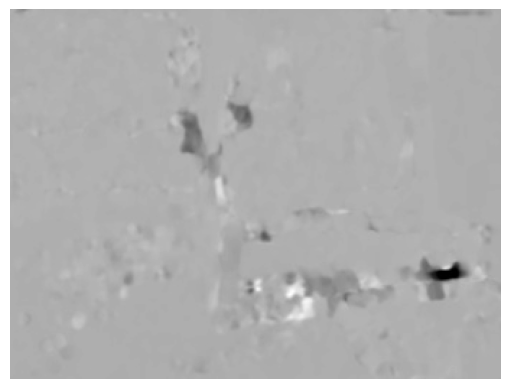

In [7]:
plt.imshow(frame_x, cmap='gray')
plt.axis('off')
plt.show()

In [8]:
frame_y = cv2.imread(os.path.join(video_dir, f'flow_y_{1:05d}.jpg'), cv2.IMREAD_GRAYSCALE)
frame_y = np.array(frame_y)

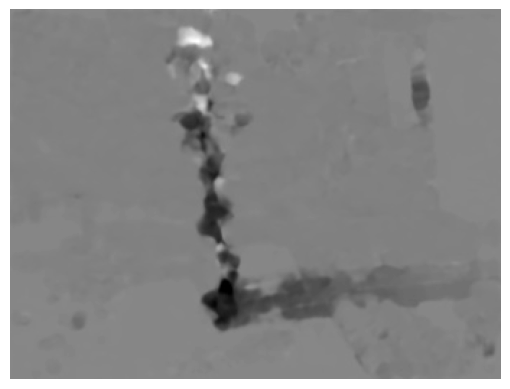

In [9]:
plt.imshow(frame_y, cmap='gray')
plt.axis('off')
plt.axis('off')
plt.show()

In [10]:
# blend OF x and y components
flow_x = (frame_x.astype(np.float32) - 128) / 128
flow_y = (frame_y.astype(np.float32) - 128) / 128

# Stack the components to create a 2-channel flow
flow = np.stack([flow_x, flow_y], axis=2)

In [11]:
rgb_flow = dlf.flow2rgb(flow)

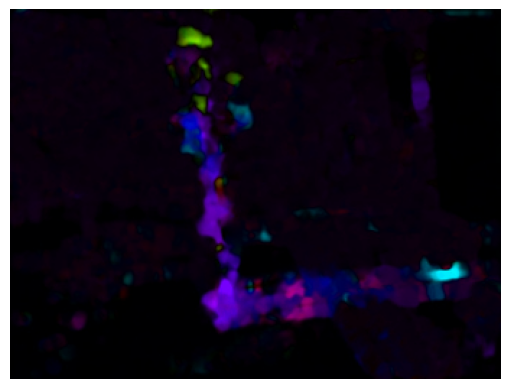

In [12]:
plt.imshow(rgb_flow)
plt.axis('off')
plt.show()

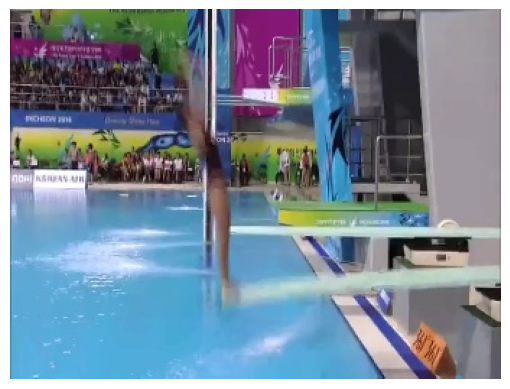

In [13]:
frame = Image.open(os.path.join(video_dir, f'img_{1:05d}.jpg'))
plt.imshow(frame)
plt.axis('off')
plt.show()

In [9]:
flow_video = dlf.read_flow(video_meta, cfg.DATA.DATASET_PATH, 'rgb')
flow_video.shape

(48, 256, 340, 3)

In [21]:
dlf.vidshow(flow_video, fps=16)

HTML(value='\n    <video width="340" height="256" controls autoplay loop>\n        <source src="data:video/mp4…

In [11]:
x, *_ = diving48[video_id]
x.max(), x.shape

(tensor(2.5806), torch.Size([3, 32, 256, 256]))

In [25]:
a = dlf.postprocess_video(x, cfg.DATA.MEAN, cfg.DATA.STD)
dlf.vidshow(a, fps=16, size=(256, 256))

HTML(value='\n    <video width="256" height="256" controls autoplay loop>\n        <source src="data:video/mp4…

## 1.2 Optical Flow Mask
In this section we'll experiment with generating a mask from optical flow frames. The goal is to create a masks from our subject the diver, since we want our model to focus on the diver. This is all fine when the camera is static, in this case the only motion that is visible on camera will be of the subject. However, when the camera moves it is not clear whether the motion is from the camera or our subject. See https://claude.ai/share/3579dde3-d92d-4ab7-a0cf-4a19cc1a38c5
